# Importing Libraries

In [1]:
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import datetime as dt

from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import acf

import time
import holidays
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sn

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Collecting Data

In [3]:
# FRED
technical_names_quarterly = ['GDP']
abv_names_quarterly = ['GDP']

technical_names_monthly = ['USALOLITONOSTSAM', 'MTSDS133FMS', 'PCUOMFGOMFG', 'CROASMIDTIER', 'BSCICP02USM460S', 'BSCICP03USM665S', 'CPIAUCNS', 'FEDFUNDS', 'UNRATE']
abv_names_monthly = ['CLI', 'FD', 'PPI-TMI', 'MHYI', 'BTSCI', 'BSCICP03', 'CPI', 'FFR', 'UR']

technical_names_daily = ['DGS10', 'DGS3', 'DGS7', 'T5YIE', 'T10YIE', 'DEXUSEU']
abv_names_daily = ['DGS10','3YC', '7YC', '5IR', '10IR', 'ER-D-E']

# Yahoo Finance
technical_names_daily_yf = ['^GSPC','HO=F', '^DJI', '^FVX', '^TNX' ,'^DJA','^DJT', '^DJU', 'VIPIX', 'VINIX', 'VIEIX', 'VTSNX', 'VBTIX', 'VBIRX']
abv_names_daily_yf = ['S&P500', 'HOP', 'DJI', '5YC', '10YC', 'DJA', 'DJT', 'DJU', 'VIPIX', 'VINIX', 'VIEIX', 'VTSNX', 'VBTIX', 'VBIRX']

In [4]:
start_time = dt.datetime(2011, 1, 1)
end_time = dt.date.today()

df_quarterly = pd.DataFrame()
df_monthly = pd.DataFrame()
df_daily = pd.DataFrame()

for key in range(len(technical_names_daily_yf)):
    df_daily[abv_names_daily_yf[key]] = yf.Ticker(technical_names_daily_yf[key]).history(start=start_time, interval="1d")['Close']
df_daily.index = df_daily.index.tz_localize(None)

for key in range(len(technical_names_quarterly)):
    df_quarterly[abv_names_quarterly[key]] = web.DataReader(technical_names_quarterly[key], 'fred', start_time, end_time)

for key in range(len(technical_names_monthly)):
    df_monthly[abv_names_monthly[key]] = web.DataReader(technical_names_monthly[key], 'fred', start_time, end_time)

for key in range(len(technical_names_daily)):
    df_daily[abv_names_daily[key]] = web.DataReader(technical_names_daily[key], 'fred', start_time, end_time)

In [5]:
# Transforming monthly and quarterly to daily
df_monthly = df_monthly.reset_index()
df_quarterly = df_quarterly.reset_index()

df_monthly['DATE'] = pd.to_datetime(df_monthly['DATE']).dt.to_pydatetime()
df_monthly = df_monthly.set_index('DATE').resample('D').interpolate()
df_monthly.index = df_monthly.index.tz_localize(None)

df_quarterly['DATE'] = pd.to_datetime(df_quarterly['DATE']).dt.to_pydatetime()
df_quarterly = df_quarterly.set_index('DATE').resample('D').interpolate()
df_quarterly.index = df_quarterly.index.tz_localize(None)


In [6]:
# Combining all in one data set
df = df_daily.copy()
df = df.join(df_monthly)
df = df.join(df_quarterly)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
S&P500,3230.0,2618.637257,1019.107015,1099.229980,1855.077515,2409.569946,3348.974915,4796.560059
HOP,3227.0,2.313456,0.753873,0.610400,1.698150,2.161300,2.970450,5.135400
DJI,3230.0,22398.913786,7611.709036,10655.299805,16248.807373,21012.349609,28329.790039,36799.648438
5YC,3228.0,1.735724,0.994251,0.195000,0.961500,1.586500,2.151500,4.961000
10YC,3228.0,2.282605,0.804085,0.499000,1.748750,2.228500,2.773000,4.988000
DJA,3230.0,7586.142503,2469.516339,3642.709961,5638.374878,7254.145020,9368.689941,12360.330078
DJT,3230.0,9597.759830,3291.174533,4038.729980,7291.074951,9143.519531,11318.790283,17039.380859
DJU,3230.0,691.142115,178.116919,391.019989,529.007477,692.224976,852.535019,1071.750000
VIPIX,3230.0,8.747194,0.825278,6.938158,8.182528,8.456968,9.399738,10.744652
VINIX,3230.0,202.176474,91.678266,73.403488,131.041454,182.189697,267.841103,392.294830


In [55]:
df

,S&P500,HOP,DJI,5YC,10YC,DJA,DJT,DJU,VIPIX,VINIX,VIEIX,VTSNX,VBTIX,VBIRX,DGS10,3YC,7YC,5IR,10IR,ER-D-E,CLI,FD,PPI-TMI,BTSCI,BSCICP03,CPI,FFR,UR,GDP
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,1271.869995,2.5528,11670.750000,2.021,3.342,4069.439941,5174.930176,406.579987,7.067525,83.678139,35.592159,72.979805,7.556291,8.549393,3.36,1.03,2.74,1.82,2.31,1.3371,100.229801,-60938.645161,181.241935,18.677419,101.365071,220.293065,0.169355,9.093548,15356.027800
2011-01-04,1270.199951,2.5065,11691.179688,2.017,3.346,4067.639893,5139.000000,408.519989,7.087949,83.570229,35.201515,72.972939,7.563433,8.549393,3.36,1.04,2.72,1.86,2.35,1.3306,100.232640,-66509.967742,181.312903,18.716129,101.366821,220.328097,0.169032,9.090323,15358.317700
2011-01-05,1276.560059,2.5422,11722.889648,2.158,3.483,4073.250000,5154.589844,406.200012,7.053905,84.001884,35.524227,72.574104,7.520582,8.525080,3.50,1.16,2.86,1.94,2.42,1.3171,100.235480,-72081.290323,181.383871,18.754839,101.368571,220.363129,0.168710,9.087097,15360.607600
2011-01-06,1273.849976,2.5112,11697.309570,2.083,3.419,4066.399902,5143.970215,406.429993,7.074335,83.850792,35.430809,72.065186,7.534869,8.533176,3.44,1.11,2.80,1.96,2.41,1.3027,100.238320,-77652.612903,181.454839,18.793548,101.370320,220.398161,0.168387,9.083871,15362.897500
2011-01-07,1271.500000,2.4863,11674.759766,1.956,3.328,4072.969971,5178.450195,407.720001,7.094759,83.699722,35.345879,71.686935,7.563433,8.557489,3.34,1.02,2.69,1.91,2.36,1.2944,100.241160,-83223.935484,181.525806,18.832258,101.372070,220.433194,0.168065,9.080645,15365.187400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-26,4137.229980,3.0439,32784.300781,4.797,4.845,10714.620117,13654.459961,828.450012,9.100000,345.589996,101.279999,109.889999,9.040000,9.830000,4.86,4.89,4.86,2.37,2.42,1.0532,99.492374,-170982.200875,252.608000,-1.000000,99.132179,307.789000,5.330000,3.800000,27617.383319
2023-10-27,4117.370117,3.0519,32417.589844,4.770,4.845,10596.530273,13556.070312,812.890015,9.110000,343.929993,100.209999,109.750000,9.040000,9.840000,4.84,4.84,4.83,2.39,2.42,1.0592,99.492374,-170982.200875,252.608000,-1.000000,99.132179,307.789000,5.330000,3.800000,27617.383319
2023-10-30,4166.819824,2.9663,32928.960938,4.804,4.875,10761.150391,13826.690430,816.340027,9.100000,348.089996,101.000000,110.849998,9.020000,9.830000,4.88,4.87,4.88,2.40,2.44,1.0592,99.492374,-170982.200875,252.608000,-1.000000,99.132179,307.789000,5.330000,3.800000,27617.383319


# Cleaning Data

In [9]:
# Checking NaN values
df.isna().sum()

S&P500         0
HOP            3
DJI            0
5YC            2
10YC           2
DJA            0
DJT            0
DJU            0
VIPIX          0
VINIX          0
VIEIX          0
VTSNX          0
VBTIX          0
VBIRX          0
DGS10         25
3YC           25
7YC           25
5IR           24
10IR          24
ER-D-E        37
CLI           42
FD            42
PPI-TMI       42
MHYI        1150
BTSCI         42
BSCICP03      42
CPI           42
FFR           42
UR            42
GDP           86
dtype: int64

In [10]:
# dropping the column that has more than a thousand empty values
df = df.drop(['MHYI'], axis=1)

In [11]:
# Fill in empty values with 'pad' method
df = df.fillna(method='pad')
df.isna().sum()

S&P500      0
HOP         0
DJI         0
5YC         0
10YC        0
DJA         0
DJT         0
DJU         0
VIPIX       0
VINIX       0
VIEIX       0
VTSNX       0
VBTIX       0
VBIRX       0
DGS10       0
3YC         0
7YC         0
5IR         0
10IR        0
ER-D-E      0
CLI         0
FD          0
PPI-TMI     0
BTSCI       0
BSCICP03    0
CPI         0
FFR         0
UR          0
GDP         0
dtype: int64

# Normalizing Data

In [12]:
covariates_names = df.columns.to_list()
output_columns = ['VIPIX', 'VINIX', 'VIEIX', 'VTSNX', 'VBTIX', 'VBIRX']
# covariates_to_rmv = ['10IR', '10YC', '3YC', '5IR', '5YC', '7YC', 'BSCICP03', 'BTSCI', 'CLI', 'DGS10', 'FD', 'FFR', 'HOP']
covariates_to_rmv = []

for item in (output_columns+covariates_to_rmv):
    covariates_names.remove(item)

covariates_names.sort()

In [13]:
normalizer_cov = preprocessing.MinMaxScaler()
d = normalizer_cov.fit_transform(df[covariates_names])
df_cov = pd.DataFrame(d, columns=covariates_names)

In [14]:
normalizer_out = preprocessing.MinMaxScaler() 
d = normalizer_out.fit_transform(df[output_columns])
df_out = pd.DataFrame(d, columns=output_columns)

In [15]:
df_normalized = df_cov.join(df_out)
df_normalized.index = df.index

In [16]:
df_normalized.describe().T

,count,mean,std,min,25%,50%,75%,max
10IR,3230.0,0.608887,0.144155,0.0,0.503968,0.634921,0.714286,1.0
10YC,3230.0,0.397279,0.179082,0.0,0.278291,0.385164,0.506516,1.0
3YC,3230.0,0.268112,0.239623,0.0,0.077079,0.182556,0.350913,1.0
5IR,3230.0,0.505762,0.138565,0.0,0.420290,0.489855,0.582609,1.0
5YC,3230.0,0.323230,0.208557,0.0,0.161089,0.291859,0.410250,1.0
7YC,3230.0,0.360479,0.190237,0.0,0.226293,0.349138,0.452586,1.0
BSCICP03,3230.0,0.523403,0.230519,0.0,0.346114,0.501874,0.694543,1.0
BTSCI,3230.0,0.540585,0.176698,0.0,0.402600,0.525862,0.686422,1.0
CLI,3230.0,0.826011,0.124664,0.0,0.756387,0.835186,0.922858,1.0
CPI,3230.0,0.361701,0.262735,0.0,0.164198,0.280711,0.455113,1.0


# Autocorrelation Analysis

In [17]:
n_lag=20

In [18]:
# Between covariates and Outputs
autocorrelation_dict = dict()
for label in output_columns:
    autocorrelation_df = pd.DataFrame()
    for column in covariates_names:
        autocorrelation_df[column]= ccf(df[column], df[label], adjusted=False)
    autocorrelation_dict[label] = autocorrelation_df

In [19]:
# Output vs Covariates
highcorr_dict_OC = dict()
meancorr_dict_OC = dict()

for label in autocorrelation_dict:
    meancorr_dict_OC[label] = autocorrelation_dict[label][:n_lag].mean()
    
for label in meancorr_dict_OC:
    highcorr_per_label = pd.DataFrame()
    for row in meancorr_dict_OC[label].index:
        if abs(meancorr_dict_OC[label][row])>0.3: # threshold for autocorrelation between output and covariates
            highcorr_per_label[row] = [meancorr_dict_OC[label][row]]
    highcorr_dict_OC[label] = highcorr_per_label

for key in highcorr_dict_OC:
    print(key+":")
    print(highcorr_dict_OC[key])
    print("        ")

VIPIX:
        5IR       CPI       DJA       DJI       DJT      DJU    ER-D-E        FD       GDP   PPI-TMI    S&P500        UR
0  0.500774  0.807067  0.870409  0.874288  0.838153  0.86122 -0.521305 -0.329135  0.829988  0.686866  0.898631 -0.316131
        
VINIX:
       3YC       5IR       5YC       CPI       DJA       DJI       DJT       DJU    ER-D-E       FFR       GDP   PPI-TMI    S&P500        UR
0  0.53876  0.515005  0.428685  0.936455  0.980443  0.979957  0.966008  0.941243 -0.628956  0.538917  0.964183  0.787097  0.989339 -0.545986
        
VIEIX:
        3YC       5IR       5YC       CPI       DJA       DJI       DJT       DJU    ER-D-E       FFR       GDP   PPI-TMI    S&P500        UR
0  0.410118  0.512719  0.310497  0.847097  0.967153  0.966352  0.960406  0.911624 -0.569779  0.404925  0.900632  0.682335  0.971195 -0.545394
        
VTSNX:
        3YC       5IR       5YC  BSCICP03     BTSCI       CPI       DJA       DJI       DJT       DJU    ER-D-E       FFR       GDP   PPI

In [21]:
# Covariates vs Outputs
highcorr_dict_CO = dict()
meancorr_dict_CO = dict()

for covariate in covariates_names:
    meancorr = pd.DataFrame()
    for output in output_columns:
        meancorr[output] = [float(autocorrelation_dict[output][covariate][:n_lag].mean())]
    meancorr_dict_CO[covariate] = meancorr

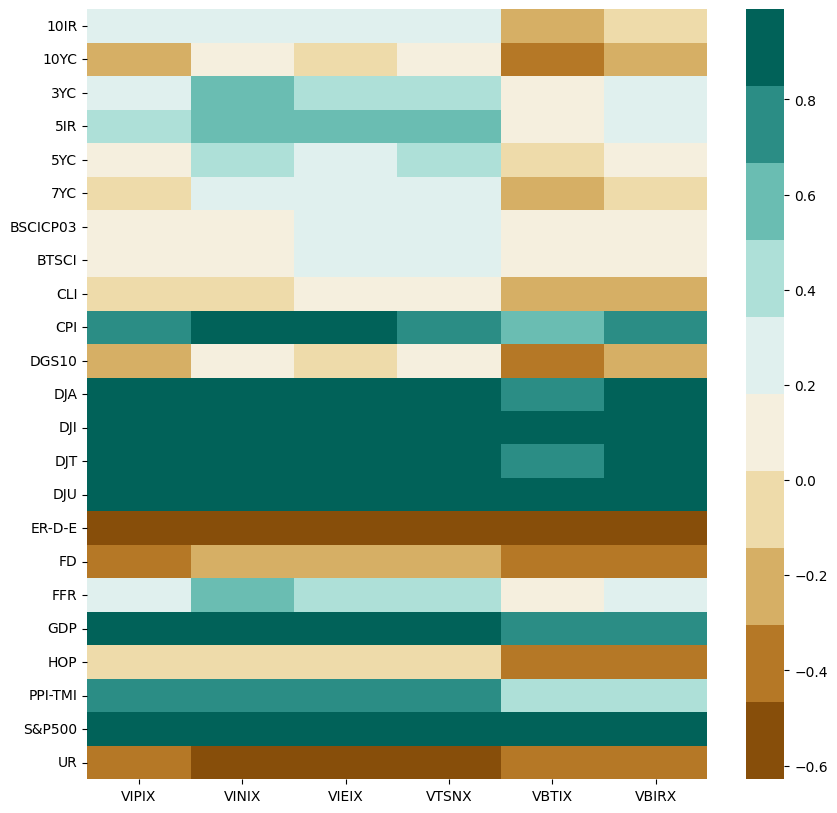

In [22]:
fig,ax = plt.subplots(figsize=(10,10))
colormap = sn.color_palette("BrBG", 10)
sn.heatmap(pd.DataFrame(meancorr_dict_OC), cmap=colormap)
plt.show()

In [23]:
# between covariates
autocorrelation_covVScov = dict()
for label in covariates_names:
    test = pd.DataFrame()
    for column in covariates_names:
        test[column]= ccf(df[column], df[label], adjusted=False)
    autocorrelation_covVScov[label] = test

In [24]:
# Covariates vs Covariates
highCOcorr_dict = dict()
meancorr_dict = dict()
meancorr = pd.DataFrame()
for label in autocorrelation_covVScov:
    n_lag=20
    meancorr[label] = autocorrelation_covVScov[label][:n_lag].mean() 
    meancorr_dict[label] = autocorrelation_covVScov[label][:n_lag].mean()

for label in meancorr.T:
    aux_label = pd.DataFrame()
    for row in meancorr.columns:
        if abs(meancorr.T[label][row])>0.3:
            aux_label[row] = pd.DataFrame(meancorr_dict[row]).T[label]
    highCOcorr_dict[label] = aux_label

cov_rmv = []
for key in highCOcorr_dict:
    print(key+":")
    print(highCOcorr_dict[key])
    if (highCOcorr_dict[key].shape[1])<6:
        cov_rmv.append(key)

10IR:
     10IR      10YC       5IR       7YC  BSCICP03     BTSCI       CLI     DGS10    ER-D-E       HOP   PPI-TMI
0  0.9616  0.411212  0.886369  0.331665  0.339152  0.339108  0.553703  0.413434  0.300202  0.784397  0.573589
10YC:
       10IR      10YC       3YC       5IR      5YC       7YC       CPI     DGS10       FFR       HOP  PPI-TMI        UR
0  0.458217  0.964003  0.776071  0.376995  0.87612  0.936616  0.324539  0.963775  0.651913  0.539622  0.48189 -0.386821
3YC:
       10YC      3YC      5IR       5YC       7YC       CPI     DGS10       DJA       DJI       DJT       DJU    ER-D-E       FFR       GDP   PPI-TMI   S&P500        UR
0  0.766961  0.97978  0.36322  0.951681  0.887205  0.714488  0.763306  0.564266  0.554647  0.578729  0.537371 -0.536797  0.899906  0.689615  0.690137  0.52727 -0.670881
5IR:
       10IR      10YC       3YC       5IR       5YC       7YC  BSCICP03     BTSCI       CLI       CPI     DGS10       DJA       DJI       DJT       DJU       GDP       HOP   PPI-TM

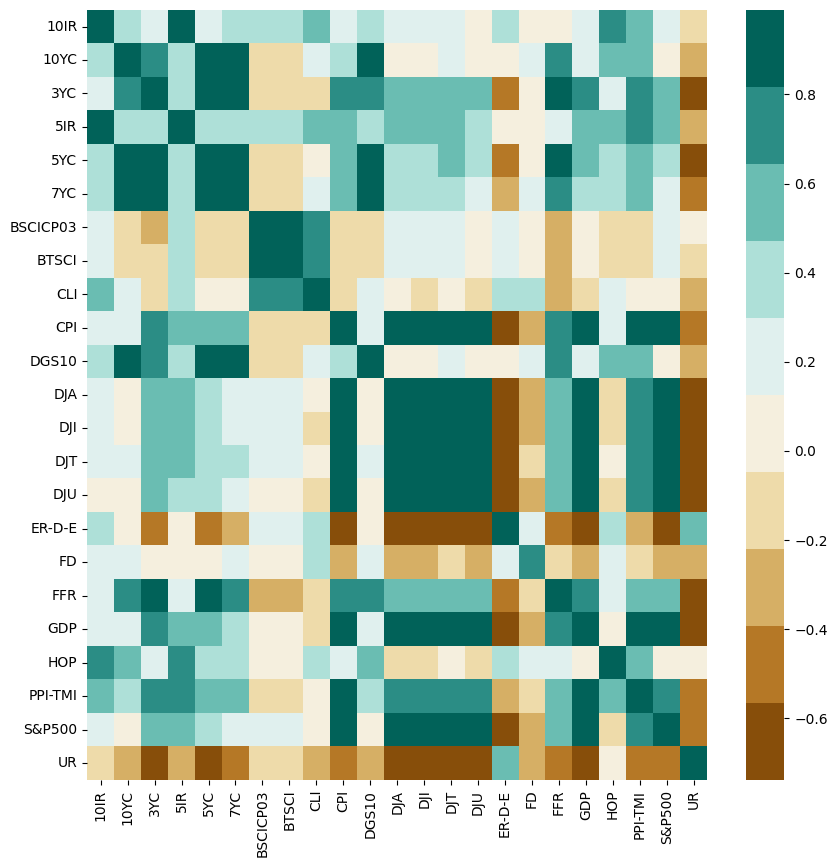

In [25]:
fig,ax = plt.subplots(figsize=(10,10))
colormap = sn.color_palette("BrBG", 10)
sn.heatmap(meancorr, cmap=colormap)
plt.show()

In [54]:
cov_rmv

['BSCICP03', 'BTSCI', 'FD']

In [26]:
df_normalized = df_normalized.drop(cov_rmv, axis=1)

# Functions

In [27]:
# Function to transform the data to a window shape
def load_data(dataframe, seq_len, steps):
    rawdata = dataframe.values
    global train_set_size, valid_set_size, test_set_size, total_size
    dataset = []
    
    for i in range(0, len(rawdata)-seq_len+1):
        dataset.append(rawdata[i:(i+seq_len), :])
    dataset = np.array(dataset)
    
    total_size = dataset.shape[0]
    valid_set_size = int(np.around((valid_set_size_perc / 100) * dataset.shape[0]))
    test_set_size = int(np.around((test_set_size_perc / 100) * dataset.shape[0]))
    train_set_size = dataset.shape[0] - (valid_set_size + test_set_size)

    print("Size: Train: ", train_set_size, "Validation: ", valid_set_size, "Testing: ", test_set_size)

    X = dataset[:, :-steps, :n_covariates]
    Y = dataset[:, -steps+1, n_covariates:]
    
    X_train = X[:train_set_size]
    Y_train = Y[:train_set_size]

    X_valid = X[train_set_size:train_set_size+valid_set_size]
    Y_valid = Y[train_set_size:train_set_size+valid_set_size]

    X_test = X[train_set_size+valid_set_size:]
    Y_test = Y[train_set_size+valid_set_size:]

    X_pred = []
    X_pred.append(dataset[-1,-seq_len+1:-steps+1, :n_covariates])
    X_pred.append(dataset[-1,-seq_len+2:, :n_covariates])
    X_pred = np.array(X_pred)

    return dict(X = X, Y = Y,
                X_train =  X_train, Y_train = Y_train, 
                X_valid = X_valid, Y_valid = Y_valid, 
                X_test = X_test, Y_test = Y_test,
                X_pred = X_pred)

In [28]:
# Function to find the next business day
ONE_DAY = dt.timedelta(days=1)
HOLIDAYS_US = holidays.US()

def next_business_day(initial_date):
    next_day = initial_date + ONE_DAY
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

In [29]:
# Function to compute goodness of fit measures
def goodness(predictions, y, n_par, split_type):
    y = np.array(y)
    predictions = np.array(predictions)
    num = len(y)
    sse = np.sum(pow(y-predictions, 2))
    rmse = np.sqrt(sse/(num))

    mape = np.sum(np.abs((y - predictions)/y))*100/num

    prr = np.sum(pow((predictions - y)/predictions, 2))

    pp = np.sum(pow((predictions - y)/y, 2))

    ssy = np.sum(pow(y - np.mean(y), 2))
    R2 = (ssy - sse)/ssy
    R2Adj = 1 - (1 - R2)*(num - 1)/(num - n_par - 1)

    if split_type=='training':
        results = {"R2": R2, "R2adj": R2Adj, "SSE": sse, "RMSE": rmse,  "MAPE": mape}
    elif split_type=='validation':
        results = {"VSSE": sse, "VRMSE": rmse}
    else:
        results = {"PSSE": sse, "PRMSE": rmse, "PRR": prr, "PP": pp}
    return results

# Modeling

In [30]:
m, n = df_normalized.shape
n_outputs = len(output_columns)
n_covariates = n-n_outputs
valid_set_size_perc = 10
test_set_size_perc = 5
lags = 20
future_step = 2

In [31]:
window_data = load_data(df_normalized, lags, future_step)

Size: Train:  2729 Validation:  321 Testing:  161


In [32]:
# Defining parameters
n_steps = lags-future_step
n_epochs = 2000
Alpha = 0.0001
loss_function = 'mse'

In [33]:
# Building architecture of neural LSTM
neurons = [12, 12]
tf.keras.backend.clear_session()

inputs = keras.Input(shape=(n_steps, n_covariates))
LSTML1 = layers.LSTM(neurons[0], activation='tanh', return_sequences=True )(inputs)
LSTML2 = layers.LSTM(neurons[1], activation='tanh')(LSTML1)
output = layers.Dense(n_outputs, activation='linear')(LSTML2)
model = keras.Model(inputs=inputs, outputs=output, name="SingleLSTM")
model.summary()

2023-11-02 13:13:24.426011: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-11-02 13:13:24.426041: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-02 13:13:24.426047: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-02 13:13:24.426436: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-02 13:13:24.426849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "SingleLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 20)]          0         
                                                                 
 lstm (LSTM)                 (None, 18, 12)            1584      
                                                                 
 lstm_1 (LSTM)               (None, 12)                1200      
                                                                 
 dense (Dense)               (None, 6)                 78        
                                                                 
Total params: 2862 (11.18 KB)
Trainable params: 2862 (11.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
# Function to reduce the learning rate during training
i = 1
def scheduler(epoch, lr):
  global i
  if epoch == i*50 and i>>100:
    i = i + 1
    return lr/10
  else:
    return lr

In [35]:
# Initializing the model
opt = keras.optimizers.legacy.Nadam(learning_rate=Alpha)
model.compile(loss=loss_function, optimizer=opt, metrics=['mae'])
callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00000001, patience=100)
callback_2 = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [36]:
# Training the model
history = model.fit(window_data["X_train"], window_data["Y_train"], epochs=n_epochs,
                    validation_data=(window_data["X_valid"], window_data["Y_valid"]), verbose=0,
                    callbacks=[callback_1, callback_2])

2023-11-02 13:13:55.588994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 13:13:56.851044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 13:13:57.687167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 13:13:59.314391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 13:14:01.356914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 13:14:09.363085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 13:14:09.432671: I tensorflow/core/grappler/optimizers/cust

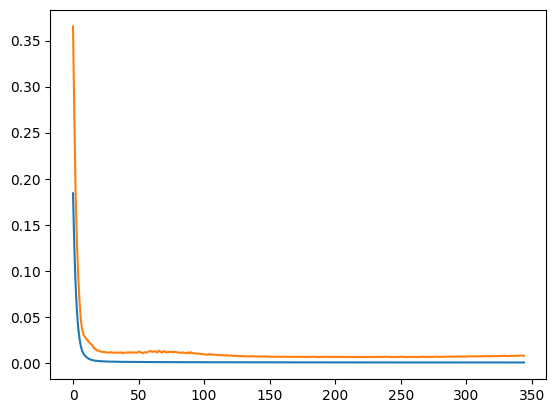

In [37]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

In [38]:
# Predicting using the entire dataset except the last two windows
Y_pred = pd.DataFrame(model.predict(window_data["X"]), columns=output_columns)
Y_pred = Y_pred.set_index(df_normalized.index[n_steps+1:])

# Transforming the output to a DataFrame
Y_test = pd.DataFrame(window_data["Y"], columns=output_columns)
Y_test = Y_test.set_index(df_normalized.index[n_steps+1:])

2023-11-02 13:25:47.373823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 13:25:47.436856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 13:25:47.989785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


101/101 [==============================] - 2s 9ms/step


In [39]:
# Evaluating the model using the entire dataset except the last two windows
model.evaluate(window_data["X"], window_data["Y"])

101/101 [==============================] - 1s 11ms/step - loss: 0.0019 - mae: 0.0225


[0.0018856193637475371, 0.0225263349711895]

In [40]:
residuo = pd.DataFrame((Y_test - Y_pred), columns=output_columns)
residuo.describe().T

,count,mean,std,min,25%,50%,75%,max
VIPIX,3211.0,0.005703,0.028207,-0.119689,-0.009941,0.001342,0.016311,0.140432
VINIX,3211.0,0.013305,0.051829,-0.123384,-0.005805,0.001604,0.009755,0.308859
VIEIX,3211.0,-0.015550,0.048855,-0.243473,-0.013689,-0.000324,0.009352,0.078635
VTSNX,3211.0,0.011313,0.059286,-0.201553,-0.016318,0.003843,0.021344,0.335770
VBTIX,3211.0,-0.003362,0.017510,-0.106236,-0.009744,-0.000957,0.006418,0.070469
VBIRX,3211.0,0.006498,0.031528,-0.143832,-0.005167,0.002579,0.011032,0.198395


In [41]:
Y_pred

,VIPIX,VINIX,VIEIX,VTSNX,VBTIX,VBIRX
Date,,,,,,
2011-01-31,0.046632,0.037096,0.069735,0.189577,0.037124,0.022003
2011-02-01,0.046744,0.036079,0.069510,0.190059,0.038418,0.023198
2011-02-02,0.047434,0.035460,0.069957,0.191912,0.038648,0.023664
2011-02-03,0.047789,0.035900,0.070865,0.194845,0.037648,0.023538
2011-02-04,0.047207,0.036816,0.071022,0.197367,0.035714,0.022382
...,...,...,...,...,...,...
2023-10-26,0.586315,0.591438,0.701391,0.388028,0.468022,0.473965
2023-10-27,0.584279,0.588459,0.698980,0.381303,0.464302,0.470798
2023-10-30,0.584693,0.584650,0.695495,0.376205,0.465278,0.470214


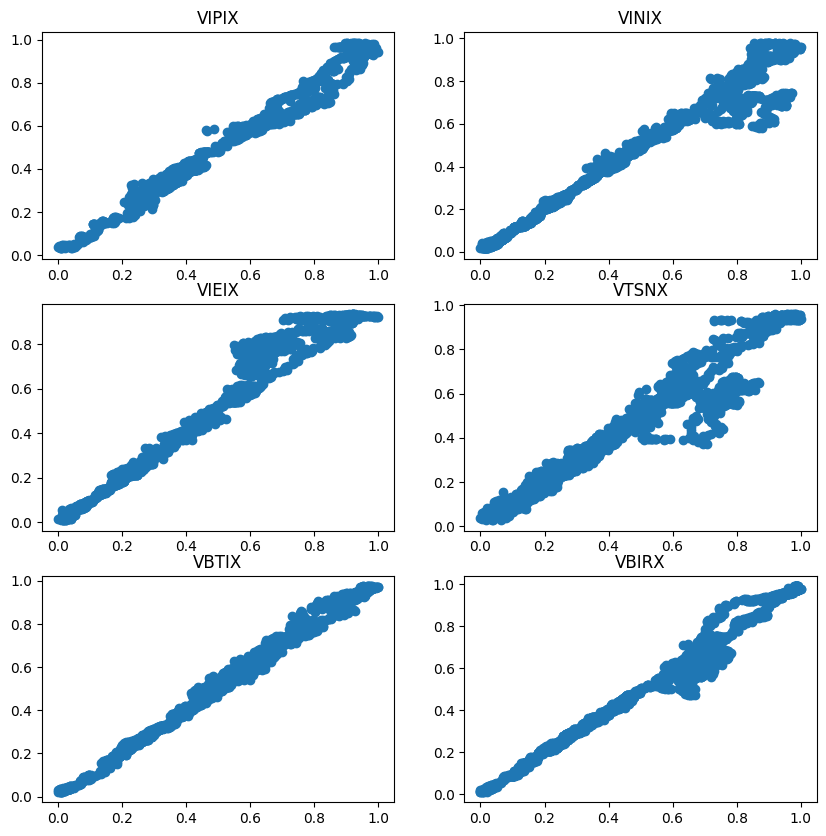

In [42]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(10,10)
i, j = 0, 0
for label in output_columns:
    axs[i,j].scatter(Y_test[label], Y_pred[label])
    axs[i,j].set_title(label)
    if j==1:
        i=i+1
        j=0
    else:
        j=1

In [43]:
# Inverse normalization
Y_Pred_not_norm = pd.DataFrame(normalizer_out.inverse_transform(Y_pred), columns=output_columns)
Y_Pred_not_norm.index = Y_pred.index

Y_test_not_norm = pd.DataFrame(normalizer_out.inverse_transform(Y_test), columns=output_columns)
Y_test_not_norm.index = Y_test.index

# Model Fit of predictions

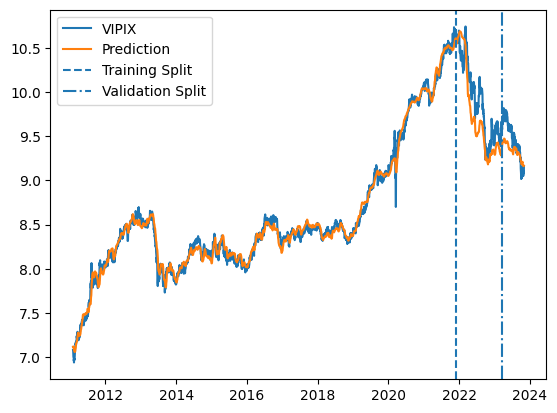

In [44]:
label = 'VIPIX'
plt.plot(Y_test_not_norm[label], label = label)
plt.plot(Y_Pred_not_norm[label], label = 'Prediction')
plt.axvline(Y_test.index[train_set_size], linestyle='--', label = 'Training Split')
plt.axvline(Y_test.index[train_set_size+valid_set_size], linestyle='-.',label = 'Validation Split')
plt.legend();

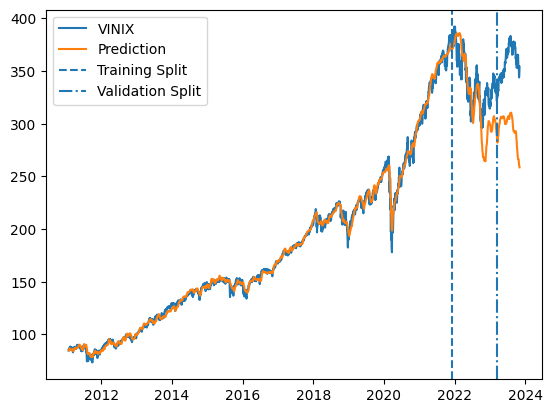

In [45]:
label = 'VINIX'
plt.plot(Y_test_not_norm[label], label = label)
plt.plot(Y_Pred_not_norm[label], label = 'Prediction')
plt.axvline(Y_test.index[train_set_size], linestyle='--', label = 'Training Split')
plt.axvline(Y_test.index[train_set_size+valid_set_size], linestyle='-.',label = 'Validation Split')
plt.legend();

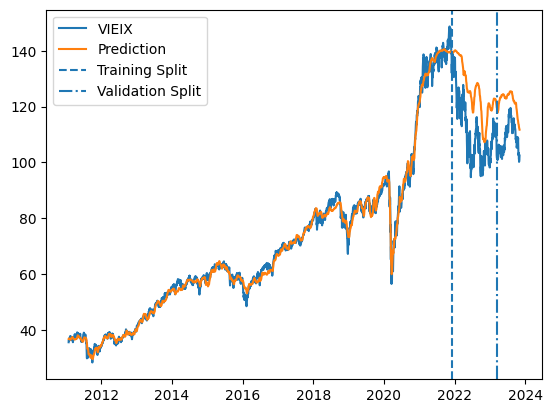

In [46]:
label = 'VIEIX'
plt.plot(Y_test_not_norm[label], label = label)
plt.plot(Y_Pred_not_norm[label], label = 'Prediction')
plt.axvline(Y_test.index[train_set_size], linestyle='--', label = 'Training Split')
plt.axvline(Y_test.index[train_set_size+valid_set_size], linestyle='-.',label = 'Validation Split')
plt.legend();

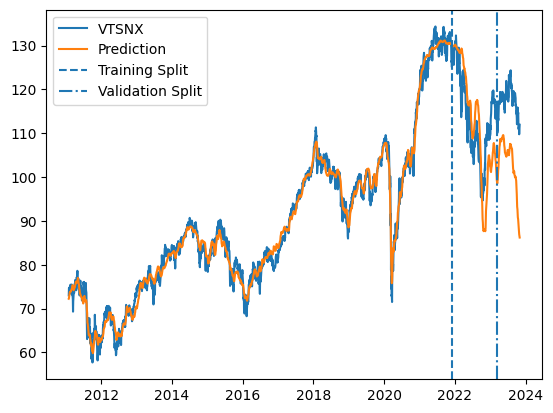

In [47]:
label = 'VTSNX'
plt.plot(Y_test_not_norm[label], label = label)
plt.plot(Y_Pred_not_norm[label], label = 'Prediction')
plt.axvline(Y_test.index[train_set_size], linestyle='--', label = 'Training Split')
plt.axvline(Y_test.index[train_set_size+valid_set_size], linestyle='-.',label = 'Validation Split')
plt.legend();

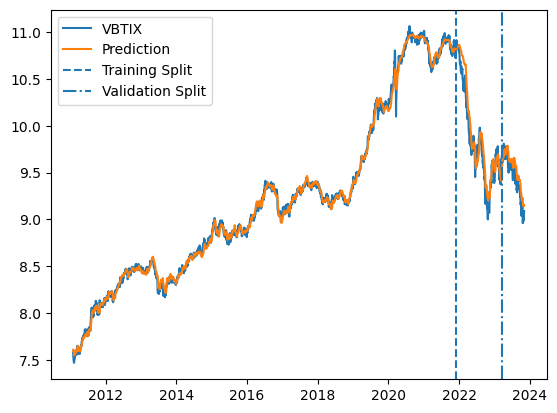

In [48]:
label = 'VBTIX'
plt.plot(Y_test_not_norm[label], label = label)
plt.plot(Y_Pred_not_norm[label], label = 'Prediction')
plt.axvline(Y_test.index[train_set_size], linestyle='--', label = 'Training Split')
plt.axvline(Y_test.index[train_set_size+valid_set_size], linestyle='-.',label = 'Validation Split')
plt.legend();

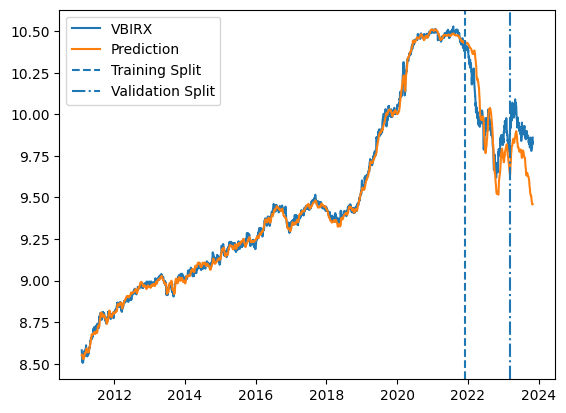

In [49]:
label = 'VBIRX' 
plt.plot(Y_test_not_norm[label], label = label)
plt.plot(Y_Pred_not_norm[label], label = 'Prediction')
plt.axvline(Y_test.index[train_set_size], linestyle='--', label = 'Training Split')
plt.axvline(Y_test.index[train_set_size+valid_set_size], linestyle='-.',label = 'Validation Split')
plt.legend();

# Goodness of fit measures

In [50]:
Goodness_results = []    
entire = {}
val = {}
pred = {}
num_par = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
for column in Y_pred:
    entire[column] = goodness(Y_pred[column], Y_test[column], num_par, split_type='training')
    val[column] = goodness(Y_pred[(m-valid_set_size-test_set_size):-test_set_size][column], Y_test.tail(valid_set_size+test_set_size-lags+1)[:-test_set_size][column], num_par, split_type='validation')
    pred[column] = goodness(Y_pred[m-test_set_size:][column], Y_test.tail(test_set_size-lags+1)[column], num_par, split_type='testing')
Goodness_results= pd.concat([pd.DataFrame(entire), pd.DataFrame(val), pd.DataFrame(pred)])
Goodness_results.T

/var/folders/h1/7qj2cfwj6r3gllfsbhlk_n200000gn/T/ipykernel_20157/4093465400.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.sum(np.abs((y - predictions)/y))*100/num
/var/folders/h1/7qj2cfwj6r3gllfsbhlk_n200000gn/T/ipykernel_20157/4093465400.py:13: RuntimeWarning: divide by zero encountered in divide
  pp = np.sum(pow((predictions - y)/y, 2))


,R2,R2adj,SSE,RMSE,MAPE,VSSE,VRMSE,PSSE,PRMSE,PRR,PP
VIPIX,0.982054,0.834461,2.658407,0.028773,inf,1.352442,0.066920,0.335548,0.048611,0.815417,0.685897
VINIX,0.965220,0.679186,9.191399,0.053502,inf,2.088581,0.083161,6.319862,0.210965,13.691788,7.579419
VIEIX,0.956449,0.598284,8.438231,0.051263,inf,5.521781,0.135219,1.777610,0.111886,2.889378,4.203168
VTSNX,0.938720,0.434748,11.693414,0.060346,inf,3.710409,0.110843,5.853136,0.203025,22.077429,9.899282
VBTIX,0.994767,0.951731,1.020501,0.017827,inf,0.478511,0.039805,0.146525,0.032123,0.483981,0.574409
VBIRX,0.985592,0.867096,3.326386,0.032186,inf,1.316983,0.066037,1.462495,0.101485,4.926151,3.185414


# Predicting the next two days

In [51]:
Pred_extra = pd.DataFrame(model.predict(window_data["X_pred"], verbose=0), columns=output_columns) # prediction

#Finding the next two business dates
future_dates = [next_business_day(Y_test.index[-1])]
for row in range(1, Pred_extra.shape[0]):
    future_dates.append(next_business_day(future_dates[-1]))

Pred_extra = pd.DataFrame(normalizer_out.inverse_transform(Pred_extra), columns=output_columns)
Pred_extra.index = future_dates
Pred_extra

,VIPIX,VINIX,VIEIX,VTSNX,VBTIX,VBIRX
2023-11-02,9.167583,258.190704,111.491096,85.976082,9.150794,9.459317
2023-11-03,9.170727,257.926117,111.273705,85.891823,9.156516,9.461762


# Last 5 real index values available

In [52]:
Y_test_not_norm[-5:]

,VIPIX,VINIX,VIEIX,VTSNX,VBTIX,VBIRX
Date,,,,,,
2023-10-26,9.10,345.589996,101.279999,109.889999,9.04,9.83
2023-10-27,9.11,343.929993,100.209999,109.750000,9.04,9.84
2023-10-30,9.10,348.089996,101.000000,110.849998,9.02,9.83
2023-10-31,9.08,350.369995,101.940002,110.870003,9.01,9.82
2023-11-01,9.16,354.049988,102.480003,111.930000,9.09,9.86


# Last index values predicted, including the two days after the last day available

In [53]:
pd.concat([Y_Pred_not_norm[-5:], Pred_extra])

,VIPIX,VINIX,VIEIX,VTSNX,VBTIX,VBIRX
2023-10-26,9.169961,262.007812,112.774895,87.438416,9.151846,9.465433
2023-10-27,9.162211,261.057800,112.484482,86.923035,9.138477,9.459037
2023-10-30,9.163788,259.843201,112.064781,86.532318,9.141985,9.457855
2023-10-31,9.166497,259.157410,111.905739,86.368637,9.148986,9.458795
2023-11-01,9.167338,258.629578,111.746559,86.195656,9.150837,9.459208
2023-11-02,9.167583,258.190704,111.491096,85.976082,9.150794,9.459317
2023-11-03,9.170727,257.926117,111.273705,85.891823,9.156516,9.461762
